<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/practicals/P3.3_seq2seq_answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P3.3 - Sequence to Sequence: Text Translation

In this practical we will develop a model for translation of sentences from German to English using the sequence to sequence architecture. 

### Learning outcomes
- Understand the basic concepts of a sequence to sequence (seq2seq) model
- How to preprocess textual data.
- How to train an seq2seq model for parametrisation of the joint probability distribution $P(y_0, ..., y_k | x_0, ..., x_n)$ over the words $Y$ in the target language, conditioned on the words $X$ of the source sentence.
- How to develop a model for translation of sentences from $P(y_0, ..., y_k | x_0, ..., x_n)$.

**References**
* [1] *Ilya Sutskever, Oriol Vinyals, Quoc V. Le, "Sequence to Sequence Learning with Neural Networks"*, NIPS, 2014. https://arxiv.org/abs/1409.3215

### Download data

We train a translation model on the multi30K dataset. The dataset was specifically designed for machine translation and evaluation tasks and contains short translations from/to English to/from German.

We will be downloading the dataset via the `torchnlp` library (command to install via pip is next to import). The dataset is then processed in a similar way as in P3.1_rnn_classification.

In [2]:
!pip install pytorch-nlp

  Using cached pytorch_nlp-0.5.0-py3-none-any.whl (90 kB)
     |████████████████████████████████| 75 kB 2.4 MB/s  eta 0:00:01


In [3]:
from torchnlp.datasets import multi30k_dataset #pip install pytorch-nlp

train_data, test_data = multi30k_dataset(train=True, test=True)


print(f"Number of training sentences: {len(train_data)}")
print(f"Number of test sentences: {len(test_data)}\n\n")


test_iterator = iter(test_data)
for _ in range(3):
    batch = next(test_iterator)
    print("DE: " + batch['de'])
    print("EN: " + batch['en'] + '\n')


Number of training sentences: 29000
Number of test sentences: 1000


DE: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
EN: A man in an orange hat starring at something.

DE: Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.
EN: A Boston Terrier is running on lush green grass in front of a white fence.

DE: Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt.
EN: A girl in karate uniform breaking a stick with a front kick.



# Preprocessing textual input data

### Create vocabulary
As we have seen in practical P1.2 and P3.2, word embeddings are useful for encoding words into vectors of real numbers. The first step is to build a custom vocabulary from the raw training dataset. To this end, we tokenize each sentence and thereafter count the number of occurances of each token (=word or punctuation mark) in each of the articles using `counter`. Finally, we create the vocabulary by using the frequencies of each token in the counter. 

Note that each datapoint consists of a German and English sentence, thus we create seperate tokenizers and vocabulary for both languages. Futhermore, we add special tokens to both vocabulary: $<unk>$ for unknown tokens, $<pad>$ for padding, $<start>$ and $<end>$ as the first and last tokens of each sentence, respectively.

In [10]:
# !python -m spacy download de
# !python -m spacy download en

In [11]:
import torch
from collections import Counter
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import spacy
from tqdm.notebook import tqdm

de_counter, en_counter = Counter(), Counter()

de_tokenizer = de_tokenizer = get_tokenizer('spacy', language='de')
en_tokenizer = en_tokenizer = get_tokenizer('spacy', language='en')

for batch in tqdm(train_data):
    
    en, de = batch.values()
    
    de_counter.update(de_tokenizer(de))
    en_counter.update(en_tokenizer(en))
    
    
de_vocab = Vocab(de_counter, min_freq=2, specials=['<unk>', '<start>', '<stop>', '<pad>'])
en_vocab = Vocab(en_counter, min_freq=2, specials=['<unk>', '<start>', '<stop>', '<pad>'])

print(f"Unique tokens in source (de) vocabulary: {len(de_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(en_vocab)}")

/data/storage8/jwillems/anaconda3/envs/torch/lib/python3.9/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "de" could not be loaded, trying "de_core_news_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')
/data/storage8/jwillems/anaconda3/envs/torch/lib/python3.9/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


  0%|          | 0/29000 [00:00<?, ?it/s]

Unique tokens in source (de) vocabulary: 8014
Unique tokens in target (en) vocabulary: 6191


### Create pipelines 

In the paper we are implementing, they find it beneficial to reverse the order of the input which they believe "introduces many short term dependencies in the data that make the optimization problem much easier". We adopt this approach and reverse the German sentence after it has been transformed into a list of tokens.

**Exercise**

Complete the pipeline functions that preprocess German and English sentences respectively. The German sentences should be reversed first. Then, for both German and English sentences your code should add start and stop tokens to each sentence at appropriate positions. 

In [12]:
def de_pipeline(text):
    """
    Reverses German sentence and tokizes from a string into a list of strings (tokens). Then converts each token
    to corresponding indices. Furthermore, it adds a start token at the appropriate position.
    """
    ### Your code here ###
    
    word_idcs = [de_vocab['<start>']]
    
    [word_idcs.append(de_vocab.stoi[token]) for token in de_tokenizer(text)[::-1]];
    word_idcs.append(de_vocab['<stop>'])
    
    return word_idcs

def en_pipeline(text):
    """
    Tokenizes English sentence from a string into a list of strings (tokens), then converts each token
    to corresponding indices. Furthermore, it adds a start token at the appropriate position
    """
    ### Your code here ###
    
    word_idcs = [en_vocab['<start>']]
    [word_idcs.append(en_vocab.stoi[token]) for token in en_tokenizer(text)]
    word_idcs.append(de_vocab['<stop>'])
    
    return word_idcs



The pipelines allow us to convert a string sentence into integers:

    en_pipeline('Here is an example!')
    >>> [1, 1034, 10, 28, 0, 1208, 2]

### Create DataLoaders

**Exercise**

Use the pipelines from the previous exercise to create a `collate_batch` method produces batches of source and target sentences. As you may have foreseen, the `collate_batch` will be used in the `DataLoader` which enables iterating over the dataset in batches. In each iteration, a batch of source sentences (German) and target sentences (English) should be returned. Encode the tokens of the sentences as indices by using the vocabulary. Finally, your code should pad all sequences to be able to create two tensors: one containing the input sentences, and another one for the target sentences. Pad the sequences with the appropriate special token.

In [13]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

# check if gpu is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    ### Your code here ###
    de_list, en_list = [], []
    
    # iterate over each sentence language pair in the batch
    for item in batch:
        
        _en_sentence, _de_sentence = item.values()
              
        # process label using the label_pipeline and 
        # append this processed label to a list
        de_list.append(torch.tensor(de_pipeline(_de_sentence), dtype=torch.int64))
        
        # process the input text using the text_pipeline
        # and append this processed text to a list
        en_list.append(torch.tensor(en_pipeline(_en_sentence), dtype=torch.int64))
        
    # pad sequences
    de_padded = pad_sequence(sequences = de_list, 
                             batch_first = True, 
                             padding_value = de_vocab['<pad>'])
    # pad sequences
    en_padded = pad_sequence(sequences = en_list, 
                             batch_first = True, 
                             padding_value = en_vocab['<pad>'])
    
    # return source (DE) and target sequences (EN) after transferring them to GPU (if available)
    return de_padded.to(device).T, en_padded.to(device).T



# Building the Seq2Seq translation model

In the implementation we define three objects: the encoder, the decoder and a full translation model that encapsulates the encoder and decoder. The given code also proposes the main hyperparameters that your implementation should use. Feel free to change the values of these parameters!

The referenced paper uses a 4-layer LSTM, but in the interest of training time we can reduce this to 2-layers. The concept of multi-layer RNNs is easy to expand from 2 to 4 layers.

## Encoder

The encoder takes as input a (batch) German sentence. We already converted all sentences into a zero-padded 2D matrix (shape batch_size, max_seq_len)) containing the tokens that make up the sequences. 

**Exercise**:
Complete the Encoder's class. In the `__init__(self)` you should declare the approriate layers. The encoder has to return a compact representation of the input sequence.

**Solution:**

As we have seen multiple times already, we convert each token into a vector with a word embedding layer. The embedding is then passed into the LSTM. PyTorch's LSTM initiates a hidden state of zeros (by default) and automatically updates the hidden state after seeing the word embedding of each token in the sequence. If trained properly, the rnn state of the last timestep (i.e. when all words in a sentence) contains all information that is required to translate into a different language. The rnn state of the final layer is therefore a dense representation of the input sentence that is generated by taking into account the long and short.  



In [14]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, source_vocab, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        
        self.source_vocab = source_vocab
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(len(source_vocab), emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector 
        
        Input:
        src shape:  [max_seq_len_in_batch, batch_size]

        Output:
        hidden and cell dense vectors (hidden and cell)
        which contains all sentence information, shape [n layers, batch size, hid dim]
        """
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src len, batch size, hid dim * n directions]    
        return hidden, cell

### Decoder

**Exercise**

The next step is to implement the decoder. The Decoder class aims at performing a single step of decoding, i.e. it ouputs a single token per time-step. In the first decoding step ($t=1$), the decoder takes as input the dense representation first token $y_2 = f$(<<l>start>). With these inputs, it should update the cell and hidden state and thereafter predict the first real word $s_2$ (no start token) of the target sentence. In all later decoder steps, the first layer will receive a hidden and cell state from the previous time-step, $(h_{t-1}, c_{t-1})$, and feed it through the LSTM with the current embedded token, $y_t$ (i.e the embedding that of the token predicted at the end of the previous step), to produce a new hidden and cell state, $(h_t, c_t)$. 

You should then pass the hidden state of the RNN, $h_t$, through a linear layer, $g$, to make a prediction of what the next token in the target (output) sequence should be, i.e. $\hat{y}_{t+1} = g(h_t)$. An example is provided in the diagram below.

![alt text](lstm_decoder.png "diagram")

    
**Solution**
    
The arguments and initialization are similar to the Encoder class, except we now have an output_dim which is the size of the vocabulary for the output/target. There is also the addition of the Linear layer, used to make the predictions from the top layer hidden state.
Within the forward method, we accept a batch of input tokens, previous hidden states and previous cell states. As we are only decoding one token at a time, the input tokens will always have a sequence length of 1. We unsqueeze the input tokens to add a sentence length dimension of 1. Then, similar to the encoder, we pass through an embedding layer and apply dropout. This batch of embedded tokens is then passed into the RNN with the previous hidden and cell states. This produces an output (hidden state from the top layer of the RNN), a new hidden state (one for each layer, stacked on top of each other) and a new cell state (also one per layer, stacked on top of each other). We then pass the output (after getting rid of the sentence length dimension) through the linear layer to receive our prediction. We then return the prediction, the new hidden state and the new cell state.

**Note**: as we always have a sequence length of 1, we could use nn.LSTMCell, instead of nn.LSTM, as it is designed to handle a batch of inputs that aren't necessarily in a sequence. nn.LSTMCell is just a single cell and nn.LSTM is a wrapper around potentially multiple cells. Using the nn.LSTMCell in this case would mean we don't have to unsqueeze to add a fake sequence length dimension, but we would need one nn.LSTMCell per layer in the decoder and to ensure each nn.LSTMCell receives the correct initial hidden state from the encoder. All of this makes the code less concise - hence the decision to stick with the regular nn.LSTM.

In [15]:
class Decoder(nn.Module):
    def __init__(self, target_vocab, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.target_vocab = target_vocab
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(len(target_vocab), emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, len(target_vocab))
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sentence in
        the target language
        
        Input:
        hidden shape: [n layers, max_seq_len, hid dim]
        cell shape: [n layers, batch size, hid dim]
        input shape: [batch size]
        
        Output:
        prediction shape: [batch size, num_words_target_vocabulary]
        hidden shape: [n layers, batch size, hid dim]
        cell shape: [n layers, batch size, hid dim]
        """
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

## The seq2seq model

**Exercise**

The Seq2Seq model takes in an Encoder, Decoder, and a device (used to place tensors on the GPU, if it exists).
For this implementation, we you have to ensure that the number of layers and the hidden (and cell) dimensions are equal in the Encoder and Decoder. 

Start with declaring the optimizer and loss function of the model. The loss function should not penalize if the ground truth token is the <<l>pad> token. Use the `ignore_index` input argument of the loss function to realize this behavior.


The forward method takes the source sentence, target sentence and a teacher-forcing ratio. The teacher forcing ratio is used when training our model. When decoding, at each time-step the decoder will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability 1 - `teacher_forcing_ratio`, your model should use the token that the LSTM predicted at the end of the previous step, even if it doesn't match the actual next token in the sequence. The `random.random()` will be useful here, the module has already been imported.

    

**Solution**    
The first thing we do in the forward method is to create an outputs tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, src, into the encoder and receive out final hidden and cell states.
The first input to the decoder is the start of sequence ($<start>$) token. As our `trg` tensor already has the $<start>$ token appended (see pipelimes) we get our $y_1$ by slicing into it. We know how long our target sentences should be (max_len), so we loop that many times. The last token input into the decoder is the one before the <<l>stop> token - the $<stop>$ token is never input into the decoder.
During each iteration of the loop, we:
    
- pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
     
- receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
     
- place our prediction, $\hat{y}_{t+1}$ output in our tensor of predictions `outputs`
     
- decide if we are going to "teacher force" or not
- if we do, the next input is the ground-truth next token in the sequence, `trg[t]`
- if we don't, the next input is the predicted next token in the sequence, `top1`, which we get by performing an argmax over the output tensor
    
    
Once we've made all of our predictions, we return our tensor full of predictions `outputs`
    
    
Note: our decoder loop starts at 1, not 0. This means the 0th element of our outputs tensor remains all zeros. So our trg and outputs look something like:
$$\begin{align*}
\text{trg} = [<start>&, y_1, y_2, y_3, <stop>]\\
\text{outputs} = [0&, y_1, y_2, y_3, <stop>]
\end{align*}$$
Later on when we calculate the loss, we cut off the first element of each tensor to get:
$$\begin{align*}
\text{trg} = [y_1, y_2, y_3, <stop>]\\
\text{outputs} = [y_1, y_2, y_3, <stop>]
\end{align*}$$

In [16]:
import torch.optim as optim
import random

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        ### Your code here ###
        
        self.optimizer = optim.Adam(self.parameters())
        
        TRG_PAD_IDX = en_vocab.stoi['<pad>']
        self.criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.
        
        Inputs:
        src: padded index representation of source sentences with shape [src len, batch size]
        trg:  padded index representation of target sentences with shape [trg len, batch size]
        teacher_forcing_ratio: probability to use teacher forcing, e.g. 0.5 we use ground-truth target sentence 50% of the time
        
        Outputs:
        outputs: padded index representation of the predicted sentences with shape [trg_len, batch_size, trg_vocab_size]
        """
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = len(self.decoder.target_vocab)
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

## Training

**Exercise** 

Write functions for training and evaluating your model. You should iterate over the dataset and update the weights of the networks with the computed loss value. Print the value of training and validation loss at the end of each epoch. 

Next, you will need to call your `seq2seq` model and train it using the functions that you implemented. Finally, make a plot of the training and validation accuracy.

As the model needs extensive training, it could be useful to save the best model to your (local) drive. In this way, you can do the next exercise at another time. Use the following code inside your training loop:
    
    if val_loss < best_valid_loss:
        best_val_loss = val_loss
        torch.save(seq2seq.state_dict(), 'p3.3-model.pt')
        
Don't forget to declare `best_valid_loss` at the top of the cell, e.g. with 

    best_valid_loss = float('inf')
    
Finally, the GPU memory will gradually increase which eventually triggers a memory error. Make sure to clear the GPU memory before running the forward pass using the `torch.cuda.empty_cache()` command.

**Solution**

The training and evaluation functions of P3.1 and P3.2 can be used with some  modifications: via tensor slicing we neglect the first token of each sequence in the calculations of the loss and accuracy. Furthermore, we removed the accuracy metrics.




In [17]:
BATCH_SIZE = 128
EPOCHS = 5
DROPOUT = 0.5
N_LAYERS = 2 #paper uses 4

EMB_DIM = 256  #dimension of the word embedding
HIDDEN_DIM = 512 #dimension of the lstm's hidden state

In [18]:
from tqdm.notebook import tqdm

def train(dataset, clip):
    
    seq2seq.train()
    
    epoch_loss = 0
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)
    
    for i, (src, trg) in enumerate(tqdm(dataloader)):
        
        seq2seq.optimizer.zero_grad()
        
        output = seq2seq(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = seq2seq.criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(seq2seq.parameters(), clip)
        
        seq2seq.optimizer.step()
        
        epoch_loss += loss.item()
        
        torch.cuda.empty_cache()
        
    return epoch_loss / len(dataloader)


def evaluate(dataset):
    
    seq2seq.eval()
    
    epoch_loss = 0
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)
    
    with torch.no_grad():
    
        for i, (src, trg) in enumerate(dataloader):

            output = seq2seq(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = seq2seq.criterion(output, trg)
            
            epoch_loss += loss.item()
            
            torch.cuda.empty_cache()
        
    return epoch_loss / len(dataloader)

In [19]:
# initiate seq2seq translation model
enc = Encoder(de_vocab, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
dec = Decoder(en_vocab, EMB_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)

seq2seq = Seq2Seq(enc, dec, device).to(device)

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
seq2seq.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8014, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6191, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=6191, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (criterion): CrossEntropyLoss()
)

In [20]:
import time

N_EPOCHS = 15
CLIP = 1

best_valid_loss = float('inf')


train_loss_arr = []; val_loss_arr = []
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()

    train_loss = train(train_data, CLIP)
    val_loss = evaluate(test_data)
    
    train_loss_arr.append(train_loss); val_loss_arr.append(val_loss)
    
    if val_loss < best_valid_loss:
        best_val_loss = val_loss
        torch.save(seq2seq.state_dict(), 'tut1-model.pt')
    
    print('-' * 76)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'valid loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time, 
                                           train_loss_arr[-1],
                                           val_loss_arr[-1]))
    print('-' * 76)

  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   0 | time: 39.02s | train loss    5.062 valid loss    5.026 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   1 | time: 36.66s | train loss    4.518 valid loss    4.909 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   2 | time: 36.71s | train loss    4.223 valid loss    4.627 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   3 | time: 38.51s | train loss    3.983 valid loss    4.561 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   4 | time: 37.81s | train loss    3.826 valid loss    4.368 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   5 | time: 36.63s | train loss    3.685 valid loss    4.293 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   6 | time: 37.01s | train loss    3.525 valid loss    4.222 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   7 | time: 40.83s | train loss    3.364 valid loss    4.149 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   8 | time: 38.12s | train loss    3.264 valid loss    4.067 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch   9 | time: 36.84s | train loss    3.135 valid loss    4.011 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  10 | time: 39.04s | train loss    3.009 valid loss    3.931 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  11 | time: 37.03s | train loss    2.918 valid loss    3.938 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  12 | time: 37.06s | train loss    2.812 valid loss    3.875 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  13 | time: 38.97s | train loss    2.729 valid loss    3.843 
----------------------------------------------------------------------------


  0%|          | 0/227 [00:00<?, ?it/s]

----------------------------------------------------------------------------
| end of epoch  14 | time: 38.95s | train loss    2.662 valid loss    3.823 
----------------------------------------------------------------------------


Populating the interactive namespace from numpy and matplotlib


/data/storage8/jwillems/anaconda3/envs/torch/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['CLIP', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


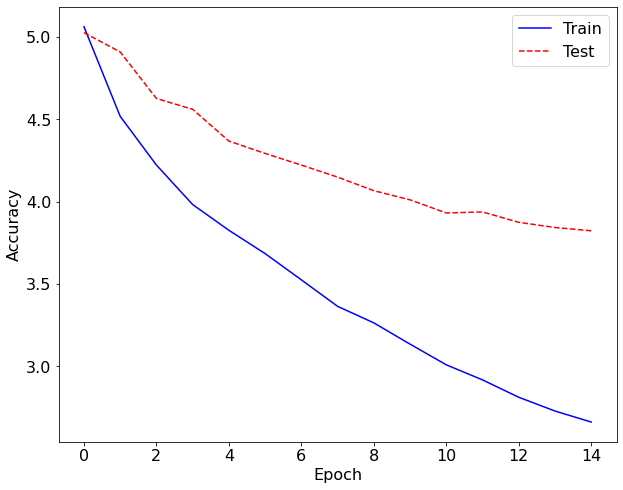

In [21]:
### Make a plot with training/testing accuracy vs. epochs ###
%pylab inline

f, ax = plt.subplots(1,1, figsize=(10,8))


fnt=16
ax.plot(train_loss_arr, color='blue', label='Train')
ax.plot(val_loss_arr, color='red', linestyle='--', label='Test')
ax.legend(fontsize=fnt)
ax.tick_params(axis='both', labelsize=fnt)

ax.set_xlabel("Epoch", fontsize=fnt)
ax.set_ylabel("Accuracy", fontsize=fnt);


# Inference

The trained model parametrizes the joint probability distribution $P(Y|X)$ of an English target sentence $Y$ that is a correct translation of the German source sentence $X$. Formally, we seek the sentence $Y$ which maximizes $P(Y|X)$, i.e. 

$$
Y = \underset{Y^{'}}{\operatorname{argmax}} p(Y^{′}|X). \quad{(1)}
$$

**Exercise** 

During inference using the seq2seq model you can make certain assumptions that should affect your implementation choices. You can assume conditional indepedance of the targets $P(Y|X)=P(y_{0:k}|X)=P(y_0|X)P(y_1|X)...P(y_k|X)$. In this case you can implement a greedy decoder that computes the most likely output at each step without taking into acount the selected outputs at previous steps. Or you can implement an autoregressive decoder that computes the joint probability of the output given the input $P(Y|X)=P(y_{0:k}|X)=P(y_0|X)P(y_1|y_0, X)...P(y_k|y_{0:k-1},X)$. 


In [22]:
def idx_to_sen(sentence_idcs, vocab):
    
    sentence_idcs = sentence_idcs[sentence_idcs > 3] #remove special tokens
                
    sentence_idcs = np.array(vocab.itos)[sentence_idcs]
                
    return ' '.join(sentence_idcs)
    
    
def print_test_examples(src, trg, pred, N):
    
    for src_, trg_, pred_ in zip(src[:N], trg[:N], pred[:N]):
        print(f' src: {src_}\n trg: {trg_}\n pred: {pred_}\n')
    
    
def greedy_decoder(dataset):
    
    seq2seq.eval()
    
    epoch_loss = 0
    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch)
    
    predf = []; srcf = []; trgf = []
    
    with torch.no_grad():
    
        for i, (src, trg) in enumerate(dataloader):

            output = seq2seq(src, trg, 0) #turn off teacher forcing

            top1 = output.argmax(2)
            
            
            for p, s, t in zip(top1.T.cpu(), src.T.cpu(), trg.T.cpu()):
                predf.append(idx_to_sen(p, en_vocab))
                srcf.append(idx_to_sen(torch.flip(s, (0, )), de_vocab))
                trgf.append(idx_to_sen(t, en_vocab)) 
        
        return srcf, trgf, predf

out = greedy_decoder(test_data)

print_test_examples(*out, N=10)

 src: Ein Mann mit einem orangefarbenen Hut , der etwas .
 trg: A man in an orange hat starring at something .
 pred: A man with a blue hat is welding .

 src: Ein Boston Terrier läuft über Gras vor einem weißen Zaun .
 trg: A Boston Terrier is running on lush green grass in front of a white fence .
 pred: A skier is running a a white dog in front of a building .

 src: Ein Mädchen in einem Karateanzug bricht einen Stock mit einem Tritt .
 trg: A girl in karate uniform breaking a stick with a front kick .
 pred: A girl in a blue outfit is a a a a .

 src: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit im Hintergrund .
 trg: Five people wearing winter jackets and helmets stand in the snow , with in the background .
 pred: Five people in life uniforms and red vests are in in the snow with trees in the background .

 src: Leute das Dach eines Hauses .
 trg: People are fixing the roof of a house .
 pred: Five people are working on a scaffold .

 src: Ein hell gekleideter Ma